In [1]:
import os
import pickle
import glob
import random
import time

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
# from sklearn import ensemble, svm
# from sklearn.metrics import balanced_accuracy_score, classification_report
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import RobustScaler, StandardScaler

import npc_lims
from npc_sessions import DynamicRoutingSession
import npc_sessions.utils
from dynamic_routing_analysis import spike_utils, decoding_utils


In [2]:
all_ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True, is_uploaded=True,))

c:\Anaconda3\envs\npc_analysis\Lib\site-packages\npc_lims\metadata\codeocean.py:208: UserWarning: There is more than one asset for session = '644866_2023-02-07'. Defaulting to most recent: ('ecephys_644866_2023-02-07_17-08-15', 'ecephys_644866_2023-02-07_17-08-15')
  warnings.warn(
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\npc_lims\metadata\codeocean.py:208: UserWarning: There is more than one asset for session = '644866_2023-02-08'. Defaulting to most recent: ('ecephys_644866_2023-02-08_16-01-11', 'ecephys_644866_2023-02-08_16-01-11')
  warnings.warn(
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\npc_lims\metadata\codeocean.py:208: UserWarning: There is more than one asset for session = '686176_2023-12-06'. Defaulting to most recent: ('ecephys_686176_2023-12-06_13-03-34', 'ecephys_686176_2023-12-06_13-03-34')
  warnings.warn(
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\npc_lims\metadata\codeocean.py:208: UserWarning: There is more than one asset for session = '664851_20

In [3]:
#load trials and facemap output for a session
session_info=all_ephys_sessions[20]
vid_angle='face'
session=DynamicRoutingSession(session_info.id)

trials=pd.read_parquet(
                npc_lims.get_cache_path('trials',session_info.id,version='any')
            )

vid_angle_npc_names={
            'behavior':'side',
            'face':'front',
            'eye':'eye',
            }

camera_to_facemap_name = {
    "face": "Face",
    "behavior": "Behavior",
}
motion_svd = npc_sessions.utils.get_facemap_output_from_s3(
            session_info.id, camera_to_facemap_name[vid_angle], "motSVD"
        )

for frame_time in session._video_frame_times:
    if vid_angle_npc_names[vid_angle] in frame_time.name:
        cam_frames=frame_time.timestamps
        break

facemap_info = {
    #'motion': behav_info['motion'],
    'motSVD': motion_svd
}

In [22]:
time_before=1.0
time_after=1.0
fps=60
keep_n_SVDs=20
rr=0
motsvd=np.asarray(facemap_info['motSVD'][:,:])
tvect=np.arange(-time_before,time_after,1/fps)

behav_SVD_by_trial={}
# behav_motion_by_trial={}
mean_trial_behav_SVD={}
# mean_trial_behav_motion={}

behav_SVD_by_trial[rr] = np.zeros((int((time_before+time_after)*fps),keep_n_SVDs,len(trials)))
# behav_motion_by_trial[rr] = np.zeros((int((time_before+time_after)*fps),len(trials)))

behav_SVD_by_trial[rr][:]=np.nan
# behav_motion_by_trial[rr][:]=np.nan

for tt,stimStartTime in enumerate(trials[:]['stim_start_time']):
    if len(np.where(cam_frames>=stimStartTime)[0])>0:
        stim_start_frame=np.where(cam_frames>=stimStartTime)[0][0]
        trial_start_frame=int(stim_start_frame-time_before*fps)
        trial_end_frame=int(stim_start_frame+time_after*fps)
        if trial_start_frame<motsvd[:,0].shape[0] and trial_end_frame<motsvd[:,0].shape[0]:
            behav_SVD_by_trial[rr][:,:,tt] = motsvd[trial_start_frame:trial_end_frame,:keep_n_SVDs]    
            # behav_motion_by_trial[rr][:,tt] = facemap_info['motion'][trial_start_frame:trial_end_frame]
        else:
            break

In [11]:
behav_SVD_by_trial[rr].shape

(120, 20, 540)

Text(0.5, 1.0, 'session 686740_2023-10-26_0')

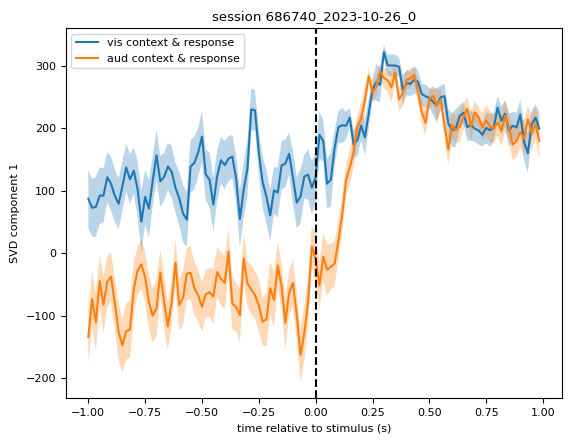

In [49]:
sel_SVD=1

line1=np.nanmean(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('is_response==True and is_vis_context').index.values],axis=1)
line1_sem=np.nanstd(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('is_response==True and is_vis_context').index.values],axis=1)/np.sqrt(len(trials.query('is_response==True and is_vis_context')))

line2=np.nanmean(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('is_response==True and is_aud_context').index.values],axis=1)
line2_sem=np.nanstd(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('is_response==True and is_aud_context').index.values],axis=1)/np.sqrt(len(trials.query('is_response==True and is_aud_context')))

fig,ax=plt.subplots(1,1)
# ax.plot(behav_SVD_by_trial[rr][:,0,:],color='gray',alpha=0.1)
ax.plot(tvect,line1,label='vis context & response',color='tab:blue')
ax.fill_between(tvect,line1-line1_sem,line1+line1_sem,alpha=0.3)
ax.plot(tvect,line2,label='aud context & response',color='tab:orange')
ax.fill_between(tvect,line2-line2_sem,line2+line2_sem,alpha=0.3)
ax.axvline(0,color='k',linestyle='--')
ax.legend()
ax.set_xlabel('time relative to stimulus (s)')
ax.set_ylabel('SVD component '+str(sel_SVD))
ax.set_title('session '+session_info.id)

In [42]:
len(trials.query('is_response==False'))

348

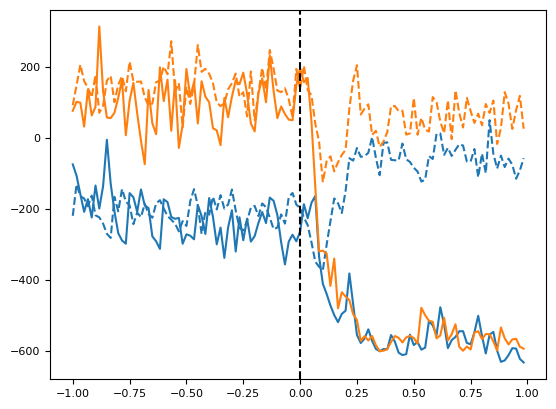

In [32]:
sel_SVD=0
fig,ax=plt.subplots(1,1)
# ax.plot(behav_SVD_by_trial[rr][:,0,:],color='gray',alpha=0.1)
ax.plot(tvect,np.nanmean(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('context_name=="vis" and is_response==True and is_correct==True').index.values],axis=1))
ax.plot(tvect,np.nanmean(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('context_name=="vis" and is_response==False and is_correct==True').index.values],axis=1),color='tab:blue',linestyle='--')
ax.plot(tvect,np.nanmean(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('context_name=="aud" and is_response==True and is_correct==True').index.values],axis=1))
ax.plot(tvect,np.nanmean(behav_SVD_by_trial[rr][:,sel_SVD,trials.query('context_name=="aud" and is_response==False and is_correct==True').index.values],axis=1),color='tab:orange',linestyle='--')
ax.axvline(0,color='k',linestyle='--')

In [ ]:
#plot facemap outputs aligned to stimuli, licks, etc.